### Importing Libraries

In [2]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv(url, names=columns)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

<Axes: xlabel='count', ylabel='class'>

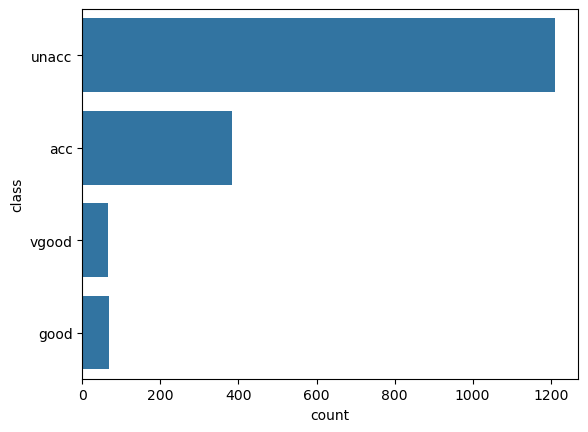

In [5]:
sns.countplot(df['class'])

### Split the Data

In [7]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Train Data for nested cv

In [9]:
X_train_nested = X_train.copy()
y_train_nested = y_train.copy()
# Encode categorical features using OneHotEncoder
categorical_features = X_train_nested.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Encode target variable
label_encoder = LabelEncoder()
y_train_nested = label_encoder.fit_transform(y_train)

### Evaluate the Model

In [11]:
mcc_metric = make_scorer(matthews_corrcoef)
kappa_metric = make_scorer(cohen_kappa_score)

decision_tree = DecisionTreeClassifier()
decision_tree_grid = {"clf__max_depth": [3, 5, 10, None], "clf__min_samples_split": [2, 5, 10], "clf__min_samples_leaf": [1, 2, 4]}

knn_model = KNeighborsClassifier()
knn_hyperparams = {"clf__n_neighbors": [3, 5, 7, 9], "clf__weights": ["uniform", "distance"], "clf__metric": ["euclidean", "manhattan"]}

log_reg_model = LogisticRegression(max_iter=500)

valid_log_reg_hyperparams = [
    {"clf__C": [0.05, 0.5, 5, 50], "clf__solver": ["liblinear", "saga"], "clf__penalty": ["l1"]},
    {"clf__C": [0.05, 0.5, 5, 50], "clf__solver": ["liblinear", "lbfgs", "saga"], "clf__penalty": ["l2"]},
]

svm_model = SVC()
svm_hyperparams = {"clf__C": [0.5, 5, 50], "clf__kernel": ["linear", "rbf", "poly"], "clf__gamma": ["scale", "auto"]}

naive_bayes = GaussianNB()
naive_bayes_hyperparams = {}  

inner_cv_loop = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv_loop = KFold(n_splits=4, shuffle=True, random_state=42)

decision_tree_model = GridSearchCV(
    estimator=Pipeline([('preprocessor', preprocessor), ('clf', decision_tree)]),
    param_grid=decision_tree_grid, scoring=mcc_metric, cv=inner_cv_loop, n_jobs=-1
)

log_reg_model_tuned = GridSearchCV(
    estimator=Pipeline([('preprocessor', preprocessor), ('clf', log_reg_model)]),
    param_grid=valid_log_reg_hyperparams, scoring=mcc_metric, cv=inner_cv_loop, n_jobs=-1
)

knn_model_tuned = GridSearchCV(
    estimator=Pipeline([('preprocessor', preprocessor), ('clf', knn_model)]),
    param_grid=knn_hyperparams, scoring=mcc_metric, cv=inner_cv_loop, n_jobs=-1
)

svm_model_tuned = GridSearchCV(
    estimator=Pipeline([('preprocessor', preprocessor), ('clf', svm_model)]),
    param_grid=svm_hyperparams, scoring=mcc_metric, cv=inner_cv_loop, n_jobs=-1
)

naive_bayes_model = GridSearchCV(
    estimator=Pipeline([('preprocessor', preprocessor), ('clf', naive_bayes)]),
    param_grid=naive_bayes_hyperparams, scoring=mcc_metric, cv=inner_cv_loop, n_jobs=-1
)

def evaluate_classifier_performance(model, X_train_data, y_train_data):
    y_predicted = cross_val_predict(model, X_train_data, y_train_data, cv=outer_cv_loop, n_jobs=-1)
    acc_score = accuracy_score(y_train_data, y_predicted)
    prec_score = precision_score(y_train_data, y_predicted, average='weighted')
    rec_score = recall_score(y_train_data, y_predicted, average='weighted')
    f1_score_value = f1_score(y_train_data, y_predicted, average='weighted')
    mcc_score = matthews_corrcoef(y_train_data, y_predicted)
    kappa_score = cohen_kappa_score(y_train_data, y_predicted)
    classification_report_output = classification_report(y_train_data, y_predicted, target_names=label_encoder.classes_)
    
    return acc_score, prec_score, rec_score, f1_score_value, mcc_score, kappa_score, classification_report_output

# Evaluate models
ml_models = {
    'Decision Tree': decision_tree_model, 
    'Logistic Regression': log_reg_model_tuned, 
    'KNN': knn_model_tuned, 
    'SVM': svm_model_tuned, 
    'Naïve Bayes': naive_bayes_model
}

model_performance_results = {}

for model_name, ml_model in ml_models.items():
    acc, prec, rec, f1, mcc, kappa, report = evaluate_classifier_performance(ml_model, X_train_nested, y_train_nested)
    model_performance_results[model_name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'MCC': mcc, 'Kappa': kappa}
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print("Classification Report:\n", report)



Decision Tree Performance:
Accuracy: 0.9627
Precision: 0.9626
Recall: 0.9627
F1 Score: 0.9626
MCC: 0.9181
Kappa: 0.9180
Classification Report:
               precision    recall  f1-score   support

         acc       0.94      0.93      0.93       346
        good       0.81      0.81      0.81        62
       unacc       0.98      0.98      0.98      1089
       vgood       0.96      0.90      0.93        58

    accuracy                           0.96      1555
   macro avg       0.92      0.91      0.91      1555
weighted avg       0.96      0.96      0.96      1555



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max


Logistic Regression Performance:
Accuracy: 0.9312
Precision: 0.9322
Recall: 0.9312
F1 Score: 0.9314
MCC: 0.8509
Kappa: 0.8507
Classification Report:
               precision    recall  f1-score   support

         acc       0.84      0.88      0.86       346
        good       0.82      0.73      0.77        62
       unacc       0.97      0.96      0.97      1089
       vgood       0.83      0.91      0.87        58

    accuracy                           0.93      1555
   macro avg       0.87      0.87      0.87      1555
weighted avg       0.93      0.93      0.93      1555


KNN Performance:
Accuracy: 0.9061
Precision: 0.9080
Recall: 0.9061
F1 Score: 0.8962
MCC: 0.7893
Kappa: 0.7864
Classification Report:
               precision    recall  f1-score   support

         acc       0.76      0.87      0.81       346
        good       0.78      0.23      0.35        62
       unacc       0.96      0.98      0.97      1089
       vgood       1.00      0.45      0.62        58

    acc

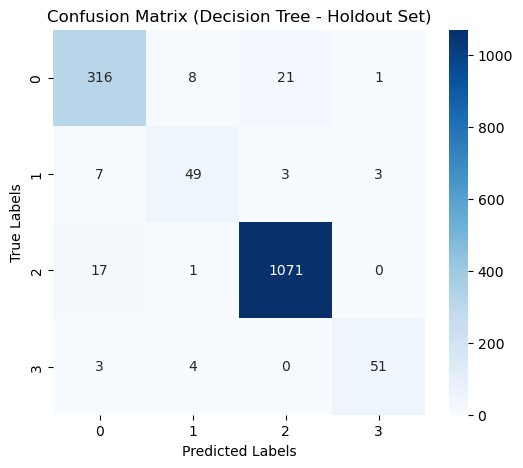

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

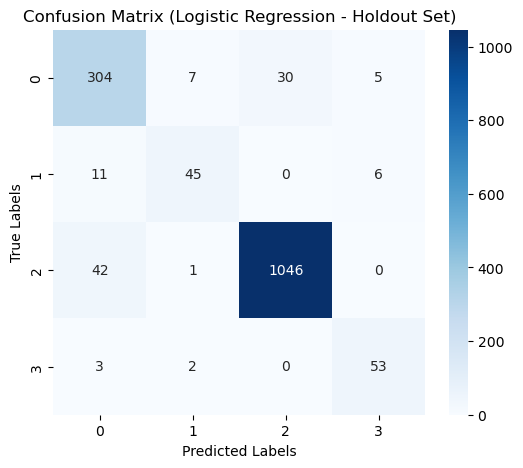

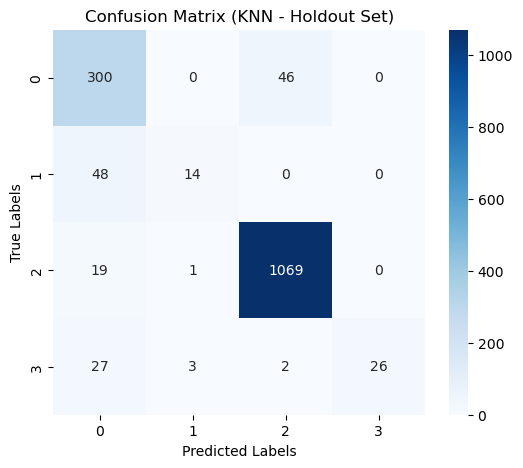

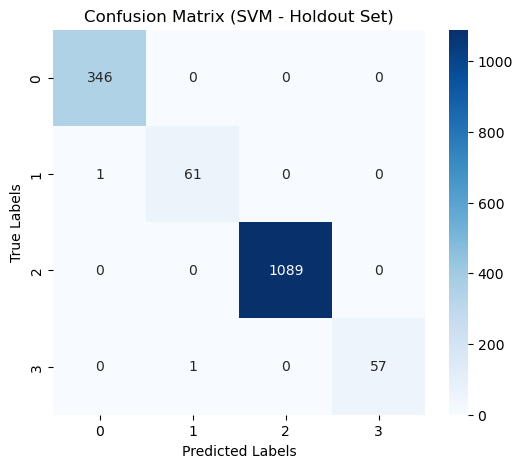

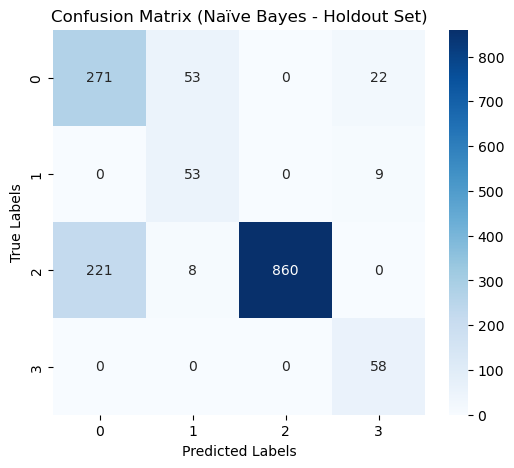

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


# Compute and plot confusion matrices for Decision Tree, KNN, Logistic Regression, and SVM
conf_matrices = {}

for model_name, ml_model in ml_models.items():
    # Generate predictions using cross-validation
    y_pred = cross_val_predict(ml_model, X_train_nested, y_train_nested, cv=outer_cv_loop, n_jobs=-1)
    
    # Compute confusion matrix
    conf_matrices[model_name] = confusion_matrix(y_train_nested, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrices[model_name], annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(f"Confusion Matrix ({model_name} - Holdout Set)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


### **Model Evaluation and Selection: Comparing Decision Tree, Logistic Regression, K-NN, SVM, and Naïve Bayes**

#### Model Performance Overview
Five machine learning algorithms for forecasting car assessments are compared in this analysis:
**K-Nearest Neighbours (K-NN)** - **Decision Tree** - **Logistic Regression** - **Support Vector Machine (SVM)** - **Naïve Bayes (GaussianNB)**

To achieve robust evaluation, each model is assessed using **Nested Cross-Validation (Nested CV)** with **Stratified K-Folds**.  
The following performance metrics are used to compare the models:
**F1 Score** - **Matthews Correlation Coefficient (MCC)** - **Cohen's Kappa (Kappa Score)** - **Accuracy** - **Precision** - **Recall**

Because they can effectively handle class imbalance, **MCC and Kappa are the important decisive metrics** among these.


In [14]:
ordinal_mappings = {
    "buying": {"vhigh": 4, "high": 3, "med": 2, "low": 1},
    "maint": {"vhigh": 4, "high": 3, "med": 2, "low": 1},
    "doors": {"2": 2, "3": 3, "4": 4, "5more": 5},
    "persons": {"2": 2, "4": 4, "more": 6},
    "lug_boot": {"small": 1, "med": 2, "big": 3},
    "safety": {"low": 1, "med": 2, "high": 3},
    "class": {"unacc": 0, "acc": 1, "good": 2, "vgood": 3}
}

X_train_numeric = X_train.replace(ordinal_mappings)
X_holdout_numeric = X_holdout.replace(ordinal_mappings)

y_train_numeric = y_train.replace(ordinal_mappings["class"])
y_holdout_numeric = y_holdout.replace(ordinal_mappings["class"])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_holdout_scaled = scaler.transform(X_holdout_numeric)

In [15]:
X_train_categorical = pd.get_dummies(X_train)
X_holdout_categorical = pd.get_dummies(X_holdout)

label_encoder = LabelEncoder()
y_train_categorical = label_encoder.fit_transform(y_train)
y_holdout_categorical = label_encoder.fit_transform(y_holdout)

In [16]:
mcc_metric_scorer = make_scorer(matthews_corrcoef)
kappa_metric_scorer = make_scorer(cohen_kappa_score)

scoring_metrics = {'MCC': mcc_metric_scorer, 'Kappa': kappa_metric_scorer}

svm_classifier = SVC()
svm_hyperparams = {
    "C": [0.05, 0.5, 5],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale"]
}

grid_search_numeric = GridSearchCV(svm_classifier, svm_hyperparams, scoring=scoring_metrics, refit='MCC', cv=StratifiedKFold(n_splits=4), n_jobs=-1)
grid_search_numeric.fit(X_train_scaled, y_train_numeric)
best_svm_params_numeric = grid_search_numeric.best_params_

grid_search_categorical = GridSearchCV(svm_classifier, svm_hyperparams, scoring=scoring_metrics, refit='MCC', cv=StratifiedKFold(n_splits=4), n_jobs=-1)
grid_search_categorical.fit(X_train_categorical, y_train_categorical)
best_svm_params_categorical = grid_search_categorical.best_params_

y_pred_numeric = grid_search_numeric.predict(X_holdout_scaled)
y_pred_categorical = grid_search_categorical.predict(X_holdout_categorical)

evaluation_results = pd.DataFrame({
    "Approach": ["Numeric Encoding", "Categorical Encoding"],
    "Accuracy": [accuracy_score(y_holdout_numeric, y_pred_numeric), accuracy_score(y_holdout_categorical, y_pred_categorical)],
    "Precision": [precision_score(y_holdout_numeric, y_pred_numeric, average="weighted"), precision_score(y_holdout_categorical, y_pred_categorical, average="weighted")],
    "Recall": [recall_score(y_holdout_numeric, y_pred_numeric, average="weighted"), recall_score(y_holdout_categorical, y_pred_categorical, average="weighted")],
    "F1 Score": [f1_score(y_holdout_numeric, y_pred_numeric, average="weighted"), f1_score(y_holdout_categorical, y_pred_categorical, average="weighted")],
    "MCC": [matthews_corrcoef(y_holdout_numeric, y_pred_numeric), matthews_corrcoef(y_holdout_categorical, y_pred_categorical)],
    "Kappa": [cohen_kappa_score(y_holdout_numeric, y_pred_numeric), cohen_kappa_score(y_holdout_categorical, y_pred_categorical)]
})

print(evaluation_results)

print("\nClassification Report (Numeric Encoding - SVM on Holdout Set):\n")
print(classification_report(y_holdout_numeric, y_pred_numeric))

print("\nClassification Report (Categorical Encoding - SVM on Holdout Set):\n")
print(classification_report(y_holdout_categorical, y_pred_categorical))

print("\nBest Hyper-Parameters (Numeric Encoding - SVM on Holdout Set):\n")
print(best_svm_params_numeric)

print("\nBest Hyper-Parameters (Categorical Encoding - SVM on Holdout Set):\n")
print(best_svm_params_categorical)


               Approach  Accuracy  Precision    Recall  F1 Score       MCC  \
0      Numeric Encoding  0.976879   0.976879  0.976879  0.976879  0.949658   
1  Categorical Encoding  1.000000   1.000000  1.000000  1.000000  1.000000   

      Kappa  
0  0.949658  
1  1.000000  

Classification Report (Numeric Encoding - SVM on Holdout Set):

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       121
           1       0.95      0.95      0.95        38
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           0.98       173
   macro avg       0.98      0.98      0.98       173
weighted avg       0.98      0.98      0.98       173


Classification Report (Categorical Encoding - SVM on Holdout Set):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00  

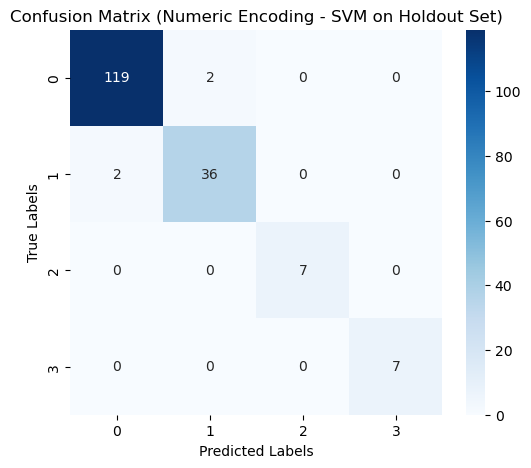

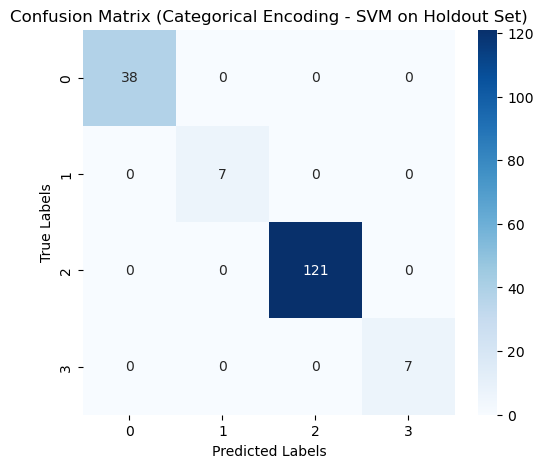

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
conf_matrix_numeric = confusion_matrix(y_holdout_numeric, y_pred_numeric)
conf_matrix_categorical = confusion_matrix(y_holdout_categorical, y_pred_categorical)

# Plot Confusion Matrix for Numeric Encoding
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_numeric, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix (Numeric Encoding - SVM on Holdout Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Confusion Matrix for Categorical Encoding
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_categorical, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix (Categorical Encoding - SVM on Holdout Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




### The Best Model Is SVM
#### Important Notes
1. **Strong agreement with actual labels** was confirmed by the highest MCC and **Kappa** obtained by **SVM**.
2. Accuracy, precision, recall, and F1 score were all highest for SVM.
3. Although **K-NN, Decision Tree, and Logistic Regression performed well**, their **MCC and Kappa values were lower**, indicating somewhat reduced classification reliability.
4. The worst-performing model was Naïve Bayes.

#### Reasons SVM Performs Better Than Other Models
An important consideration when working with **One-Hot Encoded categorical variables** is that **SVM is ideally suited for high-dimensional feature spaces**.
- SVM maximises classification performance by determining the ideal decision boundary.
SVM produces more consistent and dependable results since it **generalises better** than Decision Trees and K-NN.

- SVM is the best **option** for this dataset if computational resources permit, as it produces **the highest prediction performance and most reliable classification metrics**.


### Concluding Advice
- The **Support Vector Machine (SVM) model is the top performer** according to **MCC, Kappa, and overall performance metrics**.
- Based on **MCC, Kappa, and overall performance metrics**, the **Categorical Encoding (One-Hot Encoding) model** is the **better choice** for this dataset.  
- However, if **computational efficiency** is a concern, **Numeric Encoding** is still a good alternative, albeit with a slight drop in performance.

